# TESTING

I want to use this blog post to clear up some confusion I had recently in performing Bayesian parameter estimation using the PyMC Python library. The confusion concerns the role of the likelihood function in MCMC sampling.

I'll assume the reader is familiar with Bayes' Theorem and has some idea about how it might be applied to assign probabilities to hypotheses given data.

First let's import the usual libraries.

In [3]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Coin bias inference problem

So that we're all familiar with... coin flipping example.

In [13]:
true_coin_bias = 0.5 # The (unknown) bias of the coin
num_flips = 100

# The given data, the result of 100 coin flips
data = np.random.choice([0, 1], p=[1-true_coin_bias, true_coin_bias], size=num_flips)

# We want to infer the bias, p.
# Since p is unknown, it is a random variable.
# The distribution we assign to it here is our prior distribution on p.
p = pm.Uniform("p", lower=0, upper=1)

# We need another random variable for our observations.
# We give the relevant data to the value argument.
# The observed flag stops the value changing during MCMC exploration.
observations = pm.Bernoulli("obs", p=p, value=data, observed=True)

model = pm.Model([p, observations])
mcmc = pm.MCMC(model)

mcmc.sample(50000, 5000)

p_samples = mcmc.trace("p")[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 1.5 sec

(0, 1)

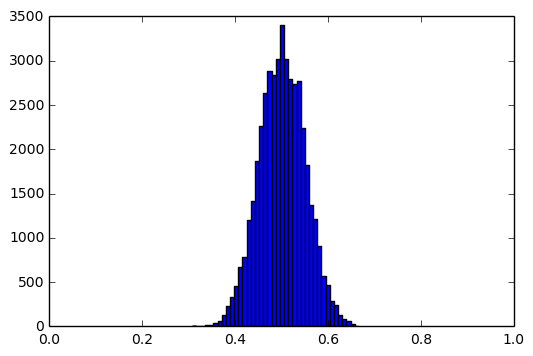

In [14]:
plt.hist(p_samples, bins=40)
plt.xlim(0,1)

## Deterministic nodes

In [34]:
true_sigma = 2.0
num_samples = 500
data = np.random.normal(scale=true_sigma, size=num_samples)

sigma = pm.Exponential("sigma", 0.01)

@pm.deterministic
def tau(sigma=sigma):
    return 1.0 / sigma**2

observations = pm.Normal("obs", 0, tau, value=data, observed=True)

model = pm.Model([sigma, observations])
mcmc = pm.MCMC(model)

mcmc.sample(50000, 5000)

sigma_samples = mcmc.trace("sigma")[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 2.3 sec

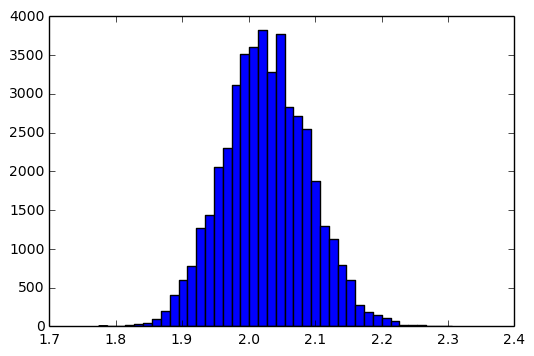

In [36]:
plt.hist(sigma_samples, bins=40);

## The lighthouse problem

Consider the following problem adapted from Gull (1988). There exists a lighthouse $\alpha$ miles along a straight coastline (relative to some position $x=0$) and $\beta$ miles offshore. As it rotates, it briefly flashes highly collimated beams of light at random intervals. We have light detectors along the coastline, and so for the $k$th time the light flashes (not counting the times the light is facing *away* from the coast) we record a position $x_k$. Given a sequence of observations, infer the position coordinates $\alpha$ and $\beta$. The relationships between all the variables for a single observation $x_k$ is shown below. Also shown is the angle $\theta_k$ that the $k$th beam makes with the line joining the lighthouse to the coast.

<img src="./img/lighthouse.png" width="300" />

### Creating the data

For simplicity, let's assume that each time the lighthouse flashes the angle of the beam is drawn uniformly between [$-\pi / 2$, $\pi / 2$].

We can see from the diagram that $\frac{x_k - \alpha}{\beta} = \tan{\theta_k}$, so $x_k = \alpha + \beta \tan{\theta_k}$. 

In [38]:
# The parameters to be inferred. We only know them here because we are synthesising the data.
true_alpha = 10
true_beta = 50

num_flashes = 100

# Generate the angles
true_thetas = np.random.uniform(low=-0.5*np.pi, high=0.5*np.pi, size=num_flashes)

# Generate the x coordinates of the flashes along the coastline
data = true_alpha + true_beta * np.tan(true_thetas)

### First attempt

In [40]:
alpha = pm.Normal("alpha", 0, 0.01)
beta = pm.Exponential("beta", 0.01)
thetas = pm.Uniform("thetas", lower=-0.5*np.pi, upper=0.5*np.pi, size=num_flashes)

Now what? What I want to do is something like the following.

In [41]:
@pm.deterministic(value=data, observed=True)
def xs(alpha=alpha, beta=beta, thetas=thetas):
  return alpha + beta * np.tan(thetas)

TypeError: __init__() got an unexpected keyword argument 'observed'

Deterministic nodes do not support setting values, and fixing those values via an *observed* flag. At first I found this confusing.